# Import

In [1]:
!pip install transformers accelerate torch

In [2]:
!pip install sqlite3 tqdm

ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3


In [3]:
!pip install sqlparse psycopg2-binary mysqlclient func_timeout pymysql

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 2.3 MB/s eta 0:00:00
  Created wheel for mysqlclient: filename=mysqlclient-2.2.7-cp312-cp312-linux_x86_64.whl size=129067 sha256=87ed51e9590623db78277183edfe2605cd480f43d3582fa702446de02333d48d
  Stored in directory: /root/.cache/pip/wheels/27/95/18/7f176fffd46629e710c04c810b9c4d7d4358fe7c96a7d2306d
  Created wheel for func_timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15077 sha256=ac37615cc2339a02cfd8256bcdccc9234ac8ff88bf897ed3d93960f7dd75999d
  Stored in directory: /root/.cache/pip/wheels/ed/94/4a/9ccd71f7284

In [4]:
from datasets import load_dataset
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch
from openai import OpenAI
import os
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Dataset Installation

In [28]:
dataset = load_dataset("birdsql/bird_mini_dev", split="mini_dev_sqlite")

df = pd.DataFrame(dataset)

README.md: 0.00B [00:00, ?B/s]

mini_dev_mysql-00000-of-00001.json: 0.00B [00:00, ?B/s]

mini_dev_pg-00000-of-00001.json: 0.00B [00:00, ?B/s]

mini_dev_sqlite-00000-of-00001.json: 0.00B [00:00, ?B/s]

Generating mini_dev_mysql split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating mini_dev_pg split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating mini_dev_sqlite split:   0%|          | 0/500 [00:00<?, ? examples/s]

# Query Selection

In [ ]:
unique_dbs = df["db_id"].unique()
print("Databases in BIRD dev set:")
for db in unique_dbs:
    print("-", db)

Databases in BIRD dev set:
- debit_card_specializing
- student_club
- thrombosis_prediction
- european_football_2
- formula_1
- superhero
- codebase_community
- card_games
- toxicology
- california_schools
- financial


Count queries per database

In [ ]:
db_counts = df["db_id"].value_counts()
print("\nNumber of queries per database is:")
print(db_counts)


Number of queries per database is:
db_id
formula_1                  66
superhero                  52
card_games                 52
european_football_2        51
thrombosis_prediction      50
codebase_community         49
student_club               48
toxicology                 40
financial                  32
debit_card_specializing    30
california_schools         30
Name: count, dtype: int64


plotting some samples

In [ ]:
print("Available columns:", df.columns.tolist())

Available columns: ['question_id', 'db_id', 'question', 'evidence', 'SQL', 'difficulty']


In [ ]:
print("\nSample queries are:")
print(df[["db_id", "difficulty"]].head(10))


Sample queries are:
                     db_id   difficulty
0  debit_card_specializing       simple
1  debit_card_specializing     moderate
2  debit_card_specializing     moderate
3  debit_card_specializing  challenging
4  debit_card_specializing     moderate
5  debit_card_specializing     moderate
6  debit_card_specializing  challenging
7  debit_card_specializing  challenging
8  debit_card_specializing       simple
9  debit_card_specializing       simple


selecting 45 queries with the defined properties

In [ ]:
# using these 3 different databases
target_dbs = ["student_club", "debit_card_specializing", "european_football_2"]
df = df[df["db_id"].isin(target_dbs)]

# adding query length column
df["query_length"] = df["question"].apply(lambda x: len(x.split()))

In [ ]:
def sample_queries(db_id, n=15):
    subset = df[df["db_id"] == db_id]
    chosen = []

    for diff in ["simple", "moderate", "challenging"]:
        diff_subset = subset[subset["difficulty"] == diff]
        if len(diff_subset) > 0:
            take_n = min(5, len(diff_subset))  # take up to 5 for diversity
            chosen.append(diff_subset.sample(n=take_n, random_state=42))
            print(chosen)

    chosen_df = pd.concat(chosen)

    # If we have fewer than n queries, fill with random from the same db
    if len(chosen_df) < n:
        remaining = n - len(chosen_df)
        extra = subset.drop(chosen_df.index).sample(n=remaining, random_state=42)
        chosen_df = pd.concat([chosen_df, extra])

    return chosen_df.sample(frac=1, random_state=42)

In [ ]:
selected_student = sample_queries("student_club")
selected_debit   = sample_queries("debit_card_specializing")
selected_euro    = sample_queries("european_football_2")

[    question_id         db_id  \
30         1312  student_club   
67         1409  student_club   
59         1392  student_club   
34         1331  student_club   
47         1361  student_club   

                                             question  \
30                     What's Angela Sanders's major?   
67       Mention the total expense used on 8/20/2019.   
59  Indicate the top source of funds received in S...   
34  What is the amount of the funds that the Vice ...   
47  What is the total cost of the pizzas for all t...   

                                             evidence  \
30  Angela Sanders is the full name; full name ref...   
67  total expense refers SUM(cost) where expense_d...   
59  top source funds refers to MAX(source); Septem...   
34  'Vice President' is a position of Student Club...   
47  total cost of the pizzas refers to SUM(cost) w...   

                                                  SQL difficulty  query_length  
30  SELECT T2.major_name FROM mem

In [ ]:
final_selection = pd.concat([selected_student, selected_debit, selected_euro]).reset_index(drop=True)

print("\nSelected 45 queries:")
print(final_selection[["db_id", "difficulty", "question", "query_length"]].head())


Selected 45 queries:
          db_id   difficulty  \
0  student_club     moderate   
1  student_club  challenging   
2  student_club       simple   
3  student_club  challenging   
4  student_club     moderate   

                                            question  query_length  
0  Indicate the name of the closed event whose co...            15  
1  Write the full names of students who received ...            19  
2                     What's Angela Sanders's major?             4  
3  Calculate the total average cost that Elijah A...            16  
4  Among the students from the Student_Club who a...            23  


save the selected queries

In [ ]:
final_selection.to_csv("selected_45_queries_assign1.csv", index=False)

# Query Generation

loading the csv file

In [5]:
queries_df = pd.read_csv("/content/selected_45_queries_assign1.csv")

defining the model

In [6]:
model_name = "Qwen/Qwen2.5-Coder-7B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)
model.eval()

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Device set to use cuda:0


producing prompt

In [25]:
schemas = {
    "student_club": (
        "Event(event_id, event_name, event_date, type, notes, location, status), "
        "Major(major_id, major_name, department, college), "
        "Zip_Code(zip_code, type, city, county, state, short_state), "
        "Attendance(link_to_event, link_to_member), "
        "Budget(budget_id, category, spent, remaining, amount, event_status, link_to_event), "
        "Expense(expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget), "
        "Income(income_id, date_received, amount, source, notes, link_to_member), "
        "Member(member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)"
    ),

    "debit_card_specializing": (
        "customers(CustomerID, Segment, Currency), "
        "gasstations(GasStationID, ChainID, Country, Segment), "
        "products(ProductID, Description), "
        "transactions_1k(TransactionID, Date, Time, CustomerID, CardID, GasStationID, ProductID, Amount, Price), "
        "yearmonth(CustomerID, Date, Consumption)"
    ),

    "european_football_2": (
        "Player_Attributes(id, player_fifa_api_id, player_api_id, date, overall_rating, potential, preferred_foot, "
        "attacking_work_rate, defensive_work_rate, crossing, finishing, heading_accuracy, short_passing, volleys, "
        "dribbling, curve, free_kick_accuracy, long_passing, ball_control, acceleration, sprint_speed, agility, reactions, "
        "balance, shot_power, jumping, stamina, strength, long_shots, aggression, interceptions, positioning, vision, penalties, "
        "marking, standing_tackle, sliding_tackle, gk_diving, gk_handling, gk_kicking, gk_positioning, gk_reflexes), "
        "Player(id, player_api_id, player_name, player_fifa_api_id, birthday, height, weight), "
        "League(id, country_id, name), "
        "Country(id, name), "
        "Team(id, team_api_id, team_fifa_api_id, team_long_name, team_short_name), "
        "Team_Attributes(id, team_fifa_api_id, team_api_id, date, buildUpPlaySpeed, buildUpPlaySpeedClass, "
        "buildUpPlayDribbling, buildUpPlayDribblingClass, buildUpPlayPassing, buildUpPlayPassingClass, "
        "buildUpPlayPositioningClass, chanceCreationPassing, chanceCreationPassingClass, chanceCreationCrossing, "
        "chanceCreationCrossingClass, chanceCreationShooting, chanceCreationShootingClass, chanceCreationPositioningClass, "
        "defencePressure, defencePressureClass, defenceAggression, defenceAggressionClass, defenceTeamWidth, "
        "defenceTeamWidthClass, defenceDefenderLineClass), "
        "Match(id, country_id, league_id, season, stage, date, match_api_id, home_team_api_id, away_team_api_id, "
        "home_team_goal, away_team_goal, home_player_X1, ..., BSA)"
    )
}

In [20]:
def build_prompt(db_id, question, evidence=None):

    schema = schemas.get(db_id, "Schema not available")
    evidence_text = f"\nEvidence: {evidence}" if evidence else ""

    # this is the later prompt which was a little general so that i change it to be better
    # prompt = f"""
    # You are an expert SQL generator.
    # Only write SQL queries that are correct and executable.
    # Do not include any explanations.

    # Database: {db_id}
    # Schema: {schema}{evidence_text}

    # Question: {question}

    # SQL:
    # """

    prompt = f"""
    You are an expert SQL generator.
    Only output valid SQLite SQL queries.
    - Use only the tables and columns given in the schema.
    - Do not invent new functions or columns.
    - Use SQLite-compatible functions (e.g., SUBSTR, CAST) instead of unsupported ones.
    - Use explicit JOINs when needed.
    - Do not include explanations.

    Database: {db_id}
    Schema: {schema}{evidence_text}

    Question: {question}

    SQL:
    """

    return prompt.strip()

generating SQL for all of the queries

In [8]:
queries_df_generation = queries_df.copy()
queries_df_generation["generated_sql"] = None

for idx, row in queries_df_generation.iterrows():
    db_id = row["db_id"]
    question = row["question"]
    evidence = row.get("evidence", None)

    prompt = build_prompt(db_id, question, evidence)

    output = pipe(prompt, max_new_tokens=256, do_sample=False)

    sql = output[0]["generated_text"].split("SQL:")[-1].strip()

    # Removing any accidental trailing instructions or newlines
    sql_lines = [line for line in sql.split("\n") if line.strip() and not line.strip().lower().startswith("do not include")]
    sql = "\n".join(sql_lines)

    queries_df_generation.at[idx, "generated_sql"] = sql
    print("end of round ", idx+1)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


end of round  1
end of round  2
end of round  3
end of round  4
end of round  5
end of round  6
end of round  7
end of round  8
end of round  9


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


end of round  10
end of round  11
end of round  12
end of round  13
end of round  14
end of round  15
end of round  16
end of round  17
end of round  18
end of round  19
end of round  20
end of round  21
end of round  22
end of round  23
end of round  24
end of round  25
end of round  26
end of round  27
end of round  28
end of round  29
end of round  30
end of round  31
end of round  32
end of round  33
end of round  34
end of round  35
end of round  36
end of round  37
end of round  38
end of round  39
end of round  40
end of round  41
end of round  42
end of round  43
end of round  44
end of round  45


In [9]:
output_file = "/content/queries_with_generated_sql.csv"
queries_df_generation.to_csv(output_file, index=False)

# Evaluation

In [21]:
generated_df = pd.read_csv("/content/queries_with_generated_sql.csv")
selected_df = pd.read_csv("/content/selected_45_queries_assign1.csv")

In [11]:
!git clone https://github.com/bird-bench/mini_dev.git

Cloning into 'mini_dev'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 253 (delta 49), reused 81 (delta 31), pack-reused 132 (from 1)
Receiving objects: 100% (253/253), 3.13 MiB | 16.02 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [12]:
os.makedirs("/content/mini_dev/sqlite", exist_ok=True)

preparing the gold file

In [31]:
sql_path = "/content/mini_dev/sqlite/mini_dev_sqlite_gold.sql"
os.makedirs(os.path.dirname(sql_path), exist_ok=True)

with open(sql_path, "w") as f:
    for _, row in selected_df.iterrows():
        sql = str(row["SQL"]).strip().rstrip(";")
        db_id = str(row["db_id"]).strip()
        f.write(f"{sql}\t{db_id}\n")

print("Saved:", sql_path)

Saved: /content/mini_dev/sqlite/mini_dev_sqlite_gold.sql


preparing the sqlite file

In [32]:
jsonl_path = "/content/mini_dev/sqlite/mini_dev_sqlite.jsonl"

with open(jsonl_path, "w") as f:
    for _, row in selected_df.iterrows():
        record = {
            "question_id": int(row["question_id"]),
            "db_id": str(row["db_id"]).strip(),
            "question": str(row["question"]).strip(),
            "evidence": str(row.get("evidence", "")).strip(),
            "SQL": str(row["SQL"]).strip().rstrip(";"),
            "difficulty": str(row.get("difficulty", "simple")).lower()
        }
        f.write(json.dumps(record, ensure_ascii=False) + "\n")

print("Saved:", jsonl_path)


Saved: /content/mini_dev/sqlite/mini_dev_sqlite.jsonl


uploading the databases

In [30]:
from google.colab import files

uploaded = files.upload()

!unzip dev_databases.zip -d /content/mini_dev/mini_dev_data/


Saving dev_databases.zip to dev_databases.zip
Archive:  dev_databases.zip
   creating: /content/mini_dev/mini_dev_data/dev_databases/debit_card_specializing/
   creating: /content/mini_dev/mini_dev_data/dev_databases/debit_card_specializing/database_description/
  inflating: /content/mini_dev/mini_dev_data/dev_databases/debit_card_specializing/database_description/customers.csv  
  inflating: /content/mini_dev/mini_dev_data/dev_databases/debit_card_specializing/database_description/gasstations.csv  
  inflating: /content/mini_dev/mini_dev_data/dev_databases/debit_card_specializing/database_description/products.csv  
  inflating: /content/mini_dev/mini_dev_data/dev_databases/debit_card_specializing/database_description/transactions_1k.csv  
  inflating: /content/mini_dev/mini_dev_data/dev_databases/debit_card_specializing/database_description/yearmonth.csv  
  inflating: /content/mini_dev/mini_dev_data/dev_databases/debit_card_specializing/debit_card_specializing.sqlite  
   creating: /

In [15]:
!sed -i 's/=/==/g' ../requirements.txt
!pip install -r ../requirements.txt

sed: can't read ../requirements.txt: No such file or directory
ERROR: Could not open requirements file: [Errno 2] No such file or directory: '../requirements.txt'


coverting csv file to json file

In [33]:
out_path = "/content/mini_dev/sql_result/my_predictions_SQLite.json"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

records = {}
for _, row in generated_df.iterrows():
    qid = str(row["question_id"])
    sql = row["generated_sql"].strip()
    db_id = row["db_id"]
    records[qid] = f"{sql};\t----- bird -----\t{db_id}"

with open(out_path, "w") as f:
    json.dump(records, f, indent=2)
print("Saved:", out_path)

Saved: /content/mini_dev/sql_result/my_predictions_SQLite.json


evaluating

In [48]:
  %cd /content/mini_dev/evaluation
!sh run_evaluation.sh

/content/mini_dev/evaluation
Differential JSON Path: ../sqlite/mini_dev_sqlite.jsonl
Ground Truth Path: ../sqlite/mini_dev_sqlite_gold.sql
starting to compare with knowledge for ex, sql_dialect: SQLite
start calculate EX
                     simple               moderate             challenging          total               
count                15                   16                   14                   45                  
======================================    EX    =====================================
EX                   66.67                50.00                57.14                57.78               
Finished EX evaluation for SQLite on Mini Dev set



starting to compare with knowledge for R-VES, sql_dialect: SQLite
start calculate R-VES
                     simple               moderate             challenging          total               
count                15                   16                   14                   45                  
===========================

# Analysis

In [49]:
results = {
    "EX": {"simple": 66.67, "moderate": 50.00, "challenging": 57.14, "total": 57.78},
    "R-VES": {"simple": 72.17, "moderate": 51.28, "challenging": 59.44, "total": 60.78},
    "Soft-F1": {"simple": 72.25, "moderate": 52.08, "challenging": 57.14, "total": 60.38},
}

df = pd.DataFrame(results).T
display(df)

,simple,moderate,challenging,total
EX,66.67,50.00,57.14,57.78
R-VES,72.17,51.28,59.44,60.78
Soft-F1,72.25,52.08,57.14,60.38


chart by difficulty

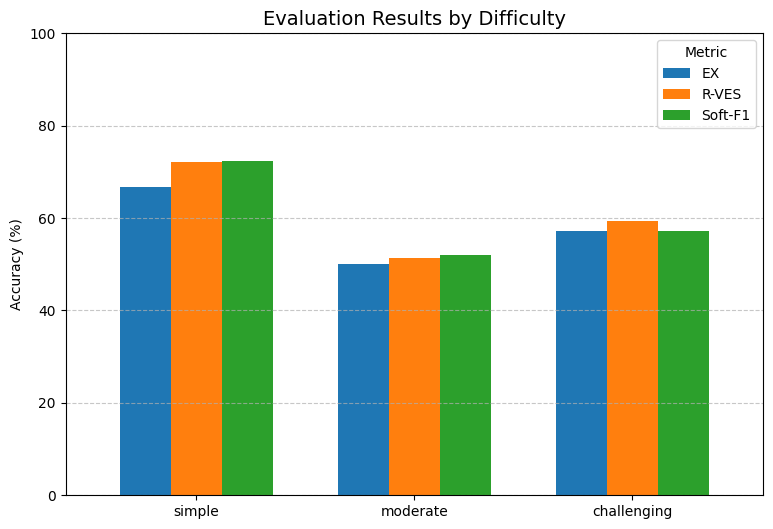

In [50]:
ax = df[["simple", "moderate", "challenging"]].T.plot(
    kind="bar", figsize=(9,6), width=0.7
)

plt.title("Evaluation Results by Difficulty", fontsize=14)
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

overall by metric

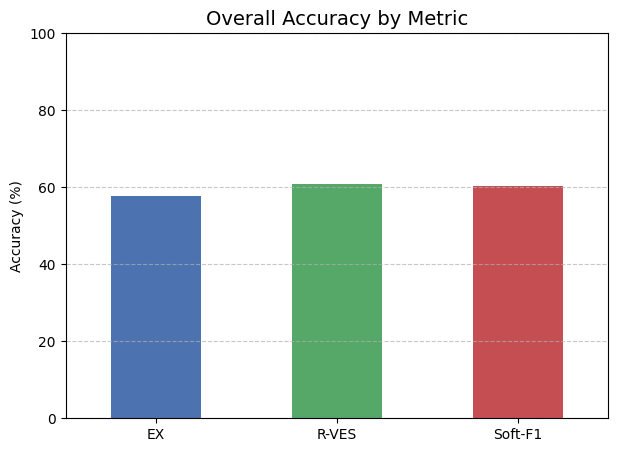

In [51]:
df["total"].plot(kind="bar", figsize=(7,5), color=["#4c72b0", "#55a868", "#c44e52"])

plt.title("Overall Accuracy by Metric", fontsize=14)
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Error rate

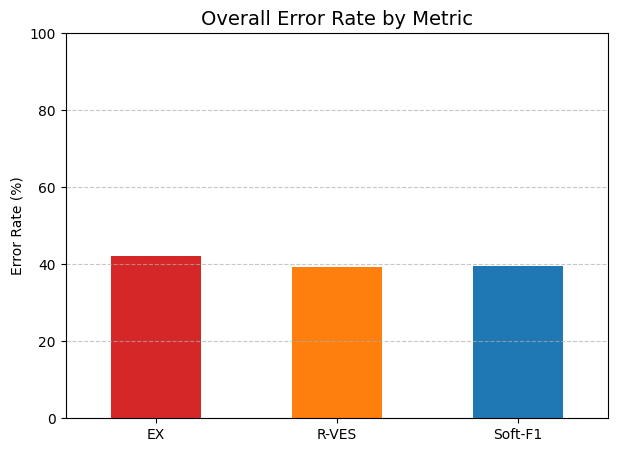

In [53]:
df_err = 100 - df

df_err["total"].plot(
    kind="bar",
    figsize=(7,5),
    color=["#d62728", "#ff7f0e", "#1f77b4"]
)

plt.title("Overall Error Rate by Metric", fontsize=14)
plt.ylabel("Error Rate (%)")
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
